<a href="https://colab.research.google.com/github/PierreSylvain/allocine-sentiment/blob/main/CamemBERT_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification de sentiments avec CamemBERT
Ce projet vise à classifier des sentiments positifs ou négatif avec le modèle CamemBERT. Les données d'entrainement, de test et de validations sont issues de Hugging Face. Ce sont les donénes extraite des commentaires du site allocine.fr.

Nous avons utilisé Pytorch pour l'entrainement du modèle.


# Citations

```
@inproceedings{martin2020camembert,
  title={CamemBERT: a Tasty French Language Model},
  author={Martin, Louis and Muller, Benjamin and Su{\'a}rez, Pedro Javier Ortiz and Dupont, Yoann and Romary, Laurent and de la Clergerie, {\'E}ric Villemonte and Seddah, Djam{\'e} and Sagot, Beno{\^\i}t},
  booktitle={Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics},
  year={2020}
}
```

>Théophile Blard, French sentiment analysis with BERT, (2020), GitHub repository, https://github.com/TheophileBlard/french-sentiment-analysis-with-bert




# Chargement des bibliothèques
Dans ce projet nous utilison PyTorch

## Installation des packages pour CamemBERT

In [1]:
!pip install transformers>=4.0
!pip install datasets
!pip install sentencepiece

     |████████████████████████████████| 312 kB 2.7 MB/s 
     |████████████████████████████████| 134 kB 34.1 MB/s 
     |████████████████████████████████| 212 kB 37.9 MB/s 
     |████████████████████████████████| 1.1 MB 38.0 MB/s 
     |████████████████████████████████| 127 kB 65.6 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 271 kB 49.7 MB/s 
     |████████████████████████████████| 144 kB 59.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 1.2 MB 3.2 MB/s 


## Bibliothèques

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score

import seaborn
from sklearn import metrics

from tqdm.notebook import tqdm # Barre de progression

In [3]:
from transformers import CamembertTokenizer
from transformers import CamembertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset

In [4]:
!nvidia-smi

Wed Mar  9 17:35:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fonctions

In [5]:
def f1_score_func(preds, labels):
  """Calcul du F1 score avec plkusiers labels"""
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

In [6]:
def accuracy_per_class(preds, labels):
  """Calcul de la précision pour chaque classe"""
  label_dict_inverted = {
      0: 'Negative',
      1: 'Positive'
  }
    
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
    
  for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat==label]
      y_true = labels_flat[labels_flat ==label]
      print(f'Class: {label_dict_inverted[label]}')
      print(f'Accuracy: {(len(y_preds[y_preds==label])/len(y_true))*100:.2f}%\n')


In [7]:
def evaluate(dataloader_val):
  """Evaluation du modèle"""
  model.eval()
    
  loss_val_total = 0
  predictions, true_vals = [], []
    
  for batch in dataloader_val:
        
      batch = tuple(b.to(device) for b in batch)
        
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2],
               }
        
      with torch.no_grad():        
          outputs = model(**inputs)
            
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
    
  loss_val_avg = loss_val_total/len(dataloader_val) 
    
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
            
  return loss_val_avg, predictions, true_vals

# Chargement des données
Le dataset provient de hugging face (https://huggingface.co/datasets/allocine)

Le jeu de données Allociné est un jeu de données en langue française pour l'analyse des sentiments. Les textes sont des critiques de films écrits entre 2006 et 2020 par des membres de la communauté Allociné.fr pour différents films. Il contient 100k critiques positives et 100k négatives divisées en train (160k), validation (20k), et test (20k).



> Théophile Blard, French sentiment analysis with BERT, (2020), GitHub repository, https://github.com/TheophileBlard/french-sentiment-analysis-with-bert


In [8]:
from datasets import load_dataset
train_ds, val_ds, test_ds = load_dataset(
    'allocine', 
    split=['train', 'validation', 'test']
)

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/866 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset allocine_dataset downloaded and prepared to /root/.cache/huggingface/datasets/allocine_dataset/allocine/1.0.0/91f700d606838c22c5c370846746e60503219d0c1f16ed96bfd1fa19a73458eb. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
train_ds['review'][:5]

['Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvemen

# Préparation des données

## Tokenisation
Encodage des données avec la version 'camembert-base'

|Modèle|nb params|Arch.|Données d'entrainement|
|-----|------|------|-------------|
|camembert-base|110M|Base|OSCAR (138 GB of text)|

> CamemBERT a été entrainé et évalué par Louis Martin*, Benjamin Muller*, Pedro Javier Ortiz Suárez*, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah et Benoît Sagot.

In [10]:
tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True
)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

### Tokenisation par lots

In [11]:
# Train
encoded_data_train = tokenizer.batch_encode_plus(
    train_ds['review'][:2000],   
    return_tensors='pt',
    max_length = 400,
    padding='longest',
    truncation=True,
    return_token_type_ids=False

)


In [12]:
# Validation
encoded_data_val = tokenizer.batch_encode_plus(
    val_ds['review'][:500],
    return_tensors='pt',
    max_length = 400,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
)

### Création des dataset

In [13]:
# Train
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_ds['label'][:2000])

dataset_train = TensorDataset(
    input_ids_train, 
    attention_masks_train, 
    labels_train)


In [14]:
# Validation
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_ds['label'][:500])

dataset_val = TensorDataset(
    input_ids_val, 
    attention_masks_val, 
    labels_val)


## Chargeur de données
On utilise des indices aléatoires pour que le modèle n'apprenne pas par rapport à l'ordre des données

In [15]:
# Train
batch_size = 16

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)


In [16]:
# Validation
batch_size = 32

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

# Modèle
Comme c'est un modèle de classification on utilise le modèle qqui est approprié.
Seulement deux labels : positif ou négatif

Nous n'avons pas besoin d'avoir le retour des tenseurs d'attentions, ni e toutes les couches d'attention.

Tout comme les couches cachées


In [17]:
model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base', 
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)


Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

## Optimizer

Utilisation de AdamW qui se veut plus performant que Adam

> AdamW est une méthode d'optimisation stochastique qui modifie l'implémentation typique de la décroissance du poids dans Adam pour combattre les problèmes de convergence connus d'Adam en découplant la décroissance du poids des mises à jour du gradient.

In [18]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5, # 2e-5 > 5e-5
    eps=1e-8
)

In [19]:
epochs = 6
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

# Initialisation

In [20]:
# Initialisation des nombres aléatoires à 17 comme Charente-Martime
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [21]:
# Utilisation de GPU (recommendé) ou CPU (vraiment très long)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [22]:
!nvidia-smi

Wed Mar  9 17:36:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |   1597MiB / 16280MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Entrainement du modèle
Cette opération est très longue, il faut compte 1 heure par époque avec un GPU

Chaque époque est enregistrée dans un fichier sur Google Drive

In [23]:
def train_model():
  """Entrainement du modèle"""
  for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(
        dataloader_train, 
        desc=f'Epoch {epoch}',
        leave=False,
        disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'./drive/MyDrive/Models/CamemBERT_V2_epoch_{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weight): {val_f1}')

train_model()

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5485933973789215
Validation loss: 0.2711553815752268
F1 Score (weight): 0.9420178675020304


Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.228515622317791
Validation loss: 0.18841451732441783
F1 Score (weight): 0.9500090003240117


Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.13684193789958954
Validation loss: 0.16229170165024698
F1 Score (weight): 0.958012938535953


Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0984685086607933
Validation loss: 0.16353804664686322
F1 Score (weight): 0.958013612410421


Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.07819048205018043
Validation loss: 0.1917600977467373
F1 Score (weight): 0.9459958959835839


Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.07326240815222264
Validation loss: 0.1781065221875906
F1 Score (weight): 0.9520138259909426


# Test du modèle

In [24]:
model = CamembertForSequenceClassification.from_pretrained("camembert-base",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False).to("cuda")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

## Chargement du modèle

In [25]:
model.load_state_dict(
    torch.load('./drive/MyDrive/Models/CamemBERT_V2_epoch_3.model',
              map_location=torch.device('cuda')))

<All keys matched successfully>

## Tokenization des données

In [26]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_ds['review'][:100],
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_ds['label'][:100])

dataset_test = TensorDataset(
    input_ids_test, 
    attention_masks_test,  
    labels_test)


In [28]:
batch_size = 32

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

## Evaluation de la prédiction

In [29]:
_, prediction, true_values = evaluate(dataloader_test)

In [30]:
accuracy_per_class(prediction, true_values)

Class: Negative
Accuracy: 93.88%

Class: Positive
Accuracy: 96.08%



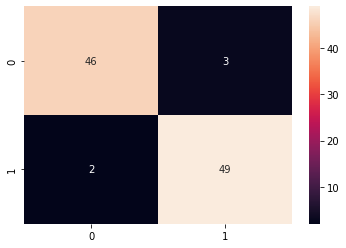

In [31]:
preds_flat = np.argmax(prediction, axis=1).flatten()
seaborn.heatmap(metrics.confusion_matrix(true_values, preds_flat),annot=True, fmt='g')

# Optimisations
Malgrès un bon score, il convient de regarder les mauvaises prédictions afin d'en déterminer la cause.

## Toneizer
**Paramètres de base pour le tokenizer**
 - max_length = 400,
 - return_tensors='pt'

**Paramètres du Tokenizer**
 - add_special_tokens=True,
 - return_attention_mask=True,
 - pad_to_max_length=True,
 - max_length=400,

| Class  | Accuracy |
|--------|----------|
|Negative| 93.88%   |
|Positive| 92.16%   |

**Nouveaux paramètres**
       
 - padding='longest',
 - truncation=True,
 - return_token_type_ids=False

| Class  | Accuracy |
|--------|----------|
|Negative| 93.88%   |
|Positive| 96.08%   |


In [32]:
tv = pd.DataFrame(true_values, columns = ['True_value'])
pv = pd.DataFrame(preds_flat, columns = ['preds'])
rv = pd.DataFrame(test_ds['review'][:100], columns = ['review'])

In [33]:
tv = tv.join(pv)
tv = tv.join(rv)
tv.head()

,True_value,preds,review
0,1,1,"Magnifique épopée, une belle histoire, touchan..."
1,0,0,Je n'ai pas aimé mais pourtant je lui mets 2 é...
2,1,1,Un dessin animé qui brille par sa féerie et se...
3,1,0,"Si c'est là le renouveau du cinéma français, c..."
4,0,0,Et pourtant on s’en Doutait !Second volet très...


In [34]:
tv[tv['True_value'] != tv['preds']]

,True_value,preds,review
3,1,0,"Si c'est là le renouveau du cinéma français, c..."
11,0,1,La Vie de David Gale est vraiment un excellent...
24,0,1,Lors de ses dernières prestations en tant qu'a...
45,0,1,Nous sommes 3 à avoir beaucoup apprécié ce fil...
80,1,0,Bon film. Certes un peu lent mais moins austèr...


In [35]:
tv['review'].iloc[31][:400]

'En tant que "stand alone", ce film aurait pu péniblement décrocher 2 étoiles. Etant le successeur de "Blair witch", ce film devient une arnaque totale, une honte incarnée. On prend le public pour des pigeons! Tout ce qui faisait le charme et la réussite du premier film est passé à la trappe. Tout tout tout! Fuyez!'

In [36]:
tv['review'].iloc[46][:400]

'Cécile de France crève l’écran en Marquise de la Pommeray, justicière calculatrice et perfide des offenses faites aux femmes. Et comme avec son patronyme, on l’imagine volontiers descendante de la Couronne du même nom, on la perçoit faite pour le rôle (bien que n’ayant aucun sang bleu). Alice Isaaz en Mademoiselle de Joncquières n’arrive en scène que tardivement et discrètement. Ce n’est pas elle '

In [37]:
tv['review'].iloc[77]

'Rien à voir avec "L\'appartement". Ce remake fait ,comme souvent avec les américain, dans la facilité en innovant aucunnement le récit ou la vision des personnages.'